In [1]:
import torch as th
import numpy as np
import seaborn as sns
import data as data_lib
import evaluation
import re_eval
import os 
import matplotlib.pyplot as plt

In [224]:
models = re_eval.load_all_important_models()
models = {k: v for k, v in models.items() if '2d' in k and 'mammal' in k}

In [242]:
name, model = models.popitem()
print(name)

..\model\data\2d\mammals.normal.2d.lr=2.0.dim=2.negs=50.burnin=10.batch=10


In [243]:
maxn = model.log.get_eval_result().epoch.max()

In [261]:
from collections import Counter
def filter_idx(_idx):
    count = Counter()
    for i, j, _ in _idx:
        count[i] += 1
        count[j] += 1
        
    ret = []
    head = Counter()
    tail = Counter()
    N = 20
    for i, j, _ in _idx:
        if count[i] < N or count[j] < N:
            continue
        if head[i]:
            continue
        ret.append((i, j, _))
        head[i] += 1
        tail[j] += 1
    return ret


209





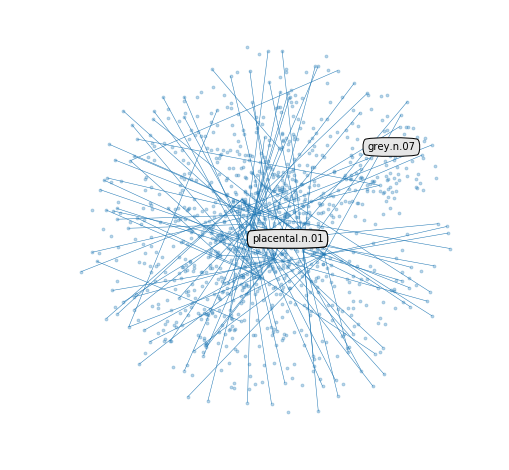

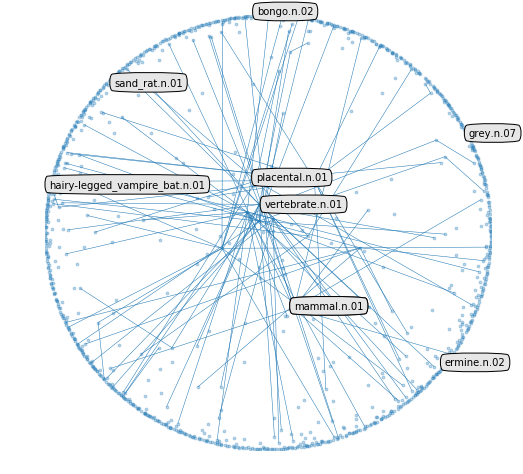

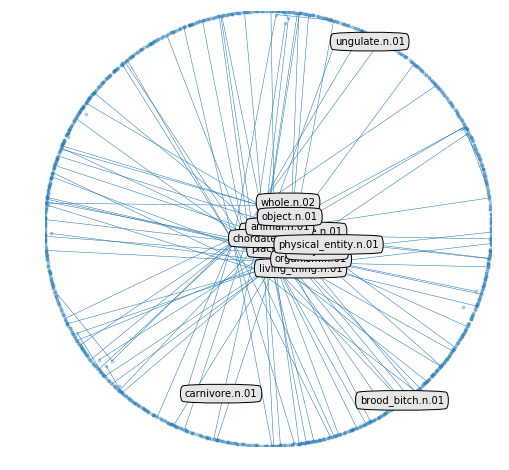

In [264]:
import matplotlib
node_num = 300000

print(maxn)
for epoch in (9, 19, maxn):
    fin = os.path.join(model.path_to_dir, '%d.nth' % (epoch, ))
    with open(fin, 'rb') as f:
        data = th.load(f)
    
    
    emb = data['model']['lt.weight']
    objs = data['objects']
    idx, _, _ = data_lib.slurp('./wordnet/mammal_closure.tsv', objects=objs)
    idx = filter_idx(idx)
    emb = emb[:node_num]
    objs = objs[:node_num]
    
    import random
    fig, ax = plt.subplots(figsize=(8, 8))
    plt.axis('off')
    ax.scatter(emb[:, 0], emb[:, 1], alpha=0.3, s=8)
    already_there = []
    segs = []
    for h, t, _ in idx:
        if h >= node_num or t >= node_num:
            continue
            
        rh = th.sqrt(th.sum(emb[h]**2))
        rt = th.sqrt(th.sum(emb[t]**2))
        di = th.sqrt(th.sum((emb[t] - emb[h])**2))
        segs.append((emb[h].tolist(), emb[t].tolist()))
    
    for i in range(len(objs)):
        r = th.sqrt(th.sum(emb[i]**2))
        if epoch != maxn or r > 0.9:
            if random.random() > np.exp(-3 * r):
                continue

            too_close = False
            for i, node in enumerate(already_there):
                dis = th.sqrt(th.sum((emb[i] - node)**2))
                if dis < 0.3:
                    too_close = True
                    break

            if too_close:
                continue
                
        already_there.append(emb[i])
        ax.annotate(objs[i], xy=(emb[i][0], emb[i][1]),  xycoords='data',
                xytext=(emb[i][0], emb[i][1]), textcoords='offset points',
                bbox=dict(boxstyle="round4,pad=.5", fc="0.9"),)

    ln_coll = matplotlib.collections.LineCollection(segs, linewidths=0.5)
    ax.add_collection(ln_coll)
    ax.set_xlim(-1, 1)    
    ax.set_ylim(-1, 1)
    plt.draw()